# 1. Read in data, choose data types.

- Why change data types?<br>
Imagine you pack a moving truck and put each pair of shoes in a large box the size of your kitchen table. You would run out of room in no time. This is the same problem faced when using this Taxi dataset. By default, many numerical columns may be read in as float 64. However, this is far too much space for the computations we will do. Thus, we use float32 where possible, and uint8 for passenger count. This greatly reduces the filesize in memory. For many with 8-16 gb of ram, you may be able to open the file with regular pandas, using this approach. However, these tutorials are also meant to showcase a real usecase of dask, so we will use it for now.

In [259]:
%%time
import dask.dataframe as dd
#path = '/Users/robertwoody/Desktop/DataSets/Taxi/csv/taxi-200900-.csv'
path = '/Users/robertwoody/Desktop/DataSets/Taxi/taxi-0.csv'
# Set columns to most suitable type to optimize for memory usage
col_types = {'fare_amount': 'float32',
              'pickup_datetime': 'str', 
              'pickup_longitude': 'float32',
              'pickup_latitude': 'float32',
              'dropoff_longitude': 'float32',
              'dropoff_latitude': 'float32',
              'passenger_count': 'uint8'}

cols = list(col_types.keys())

all_data = dd.read_csv(path, usecols=cols, dtype=col_types, parse_dates = ['pickup_datetime'])

CPU times: user 62.4 ms, sys: 13.2 ms, total: 75.7 ms
Wall time: 92.1 ms


### Lets see how many years of data we are dealing with in the data. This will take a couple minutes to run.

In [15]:
%%time
unique = all_data.pickup_datetime.dt.year
unique_year = unique.compute().unique()
print(unique_year)

CPU times: user 2min 22s, sys: 15.4 s, total: 2min 37s
Wall time: 1min 24s


In [ ]:
%%time
result_dict = {}
for year in [2009,2010,2011,2012,2013,2014]:
    
    filtered = all_data.loc[(all_data.pickup_datetime.dt.year==year),:]
    temp_result = filtered.groupby([filtered.pickup_datetime.dt.weekday,
           filtered.pickup_datetime.dt.hour]).mean().compute()
    
    temp_result.index.names = ['Weekday',"Hour"]
    temp_result = temp_result.reset_index()
    result_dict[year]=temp_result

It took a few minutes, but you applied a filter and multi index groupby operation 6 times to a 55 million row csv file. This is amazing, and you would be hard pressed to do this another way on a modest personal laptop. 

In [114]:
#Create dict of labels for our plots
day_dict = {0:"Monday",1:"Tuesday", 2: "Wednesday",
          3: "Thursday",4:"Friday",5: "Saturday",6:"Sunday"}

hour_dict = {0:"12-AM",1:"1-AM", 2:"2-AM",3:"3-AM", 4:"4-AM", 5:"5-AM",
            6:"6-AM", 7:"7-AM",8:"8-AM",9:"9-AM", 10:"10-AM", 11:"11-AM", 12:"12-PM",
            13:"1-PM",14:"2-PM", 15:"3-PM", 16:"4-PM",17:"5-PM",18:"6-PM",19:"7-PM",
            20: "8-PM", 21:"9-PM", 22:"10-PM", 23:"11-PM"}

#Grab the range of x values for plot
index = list(result.index)
#Create list of lists [Day, Hour] pairs. Why? Becomes apparent in the next cell.
labels = [[day_dict[day],hour_dict[hour]] for day,hour, in zip(result['Weekday'],result['Hour'])]

In [763]:
#Only the fare amount and passenger_count variables really matter. If we wanted, we could have removed
#the non relevant columns 
result_dict[2009].head(3)

Weekday  Hour  dropoff_latitude  dropoff_longitude  fare_amount  \
0        0     0         40.167413         -72.910949    11.197851   
1        0     1         40.141936         -72.869470    10.697418   
2        0     2         40.201817         -72.984644    10.728118   

   passenger_count  pickup_datetime  pickup_latitude  pickup_longitude  
0         1.719064              NaN        40.145776        -72.879718  
1         1.708617              NaN        40.114873        -72.830684  
2         1.696017              NaN        40.171064        -72.941567

# 2. Create Plot

In [816]:
%matplotlib inline
def average_size_year(result_dict,target_year,column,y_extent,title,y_name):
    import matplotlib
    import matplotlib as mpl
    mpl.rcParams['figure.dpi'] = 300
    #one way to use custom params for just one plot
    import matplotlib.pyplot as plt
    with plt.rc_context({ 'xtick.color':'white', 'ytick.color':'white'  }):

        fig, ax = plt.subplots(1,figsize = (21,8))
    #for all results except target year plot gray line
    for result in (list(result_dict.keys())):
        if result!=target_year:
            line_color="gray"
            alpha =.3
        else:
            line_color = "#8ef477"
            alpha = 1
        temp_result = result_dict[result]
        ax.plot(temp_result[column],linewidth=2,label=str(result),color=line_color,alpha=alpha)

    #Set the ticks for the axis
    ticks = [counter for counter,label in enumerate(labels) if counter%4==0]
    ax.set_xticks(ticks)
    ax.set_ylim(y_extent[0],y_extent[1])
    #Create labels for the x ticks
    x_labels = []
    target_result = result_dict[target_year]
    for counter,label in enumerate(labels):
        if counter %4 ==0:
            temp_label = label[1]
            if temp_label == "8-AM":
                yline = target_result[column][counter]
                y_diff = y_extent[1]-y_extent[0]
                #create vertical lines for 8AM
                ax.axvline(x = counter, ymin=0, ymax=(yline-y_extent[0])/y_diff, color="orange",linestyle='-.',
                          alpha =.8,linewidth=2.1)
                ax.axvline(x = counter, ymax=1, ymin=(yline-y_extent[0])/y_diff, color="orange",linestyle='-.',
                          alpha =.2,linewidth=2)

            if temp_label == "8-PM":
                yline = target_result[column][counter]
                #create vertical lines for 8PM
                ax.axvline(x = counter, ymin=0, ymax=(yline-y_extent[0])/y_diff, color="cyan",linestyle='-.',
                          alpha =.8,linewidth=2.1)
                ax.axvline(x = counter, ymax=1, ymin=(yline-y_extent[0])/y_diff, color="cyan",linestyle='-.',
                          alpha =.2,linewidth=2)

            if counter %24 ==0:
                #Label the start of days with day label
                temp_label = label[0]   
            x_labels.append(temp_label)

    #Set the tick labels
    ax.set_xticklabels(x_labels,rotation = 70,color="white")
    ax.set_title(title, size=16,color="white")
    ax.set_xticklabels(x_labels,rotation = 70,color="white")
    ax.set_ylabel(y_name, color = "white", size= 12)
    
    fig.patch.set_facecolor('black')
    fig.patch.set_alpha(0.9)
    
    ax.patch.set_facecolor('black')
    ax.set_facecolor('black')
    ax.patch.set_alpha(0.9)
    #No output for now
    plt.close()
    
    return fig
#Call the function 
figures = {}
for year in list(result_dict.keys()):
    figures[year] = average_size_year(result_dict,year,"passenger_count",[1.4,1.9],"Average Passengers During Week",\
                                     "Average Passenger Count")


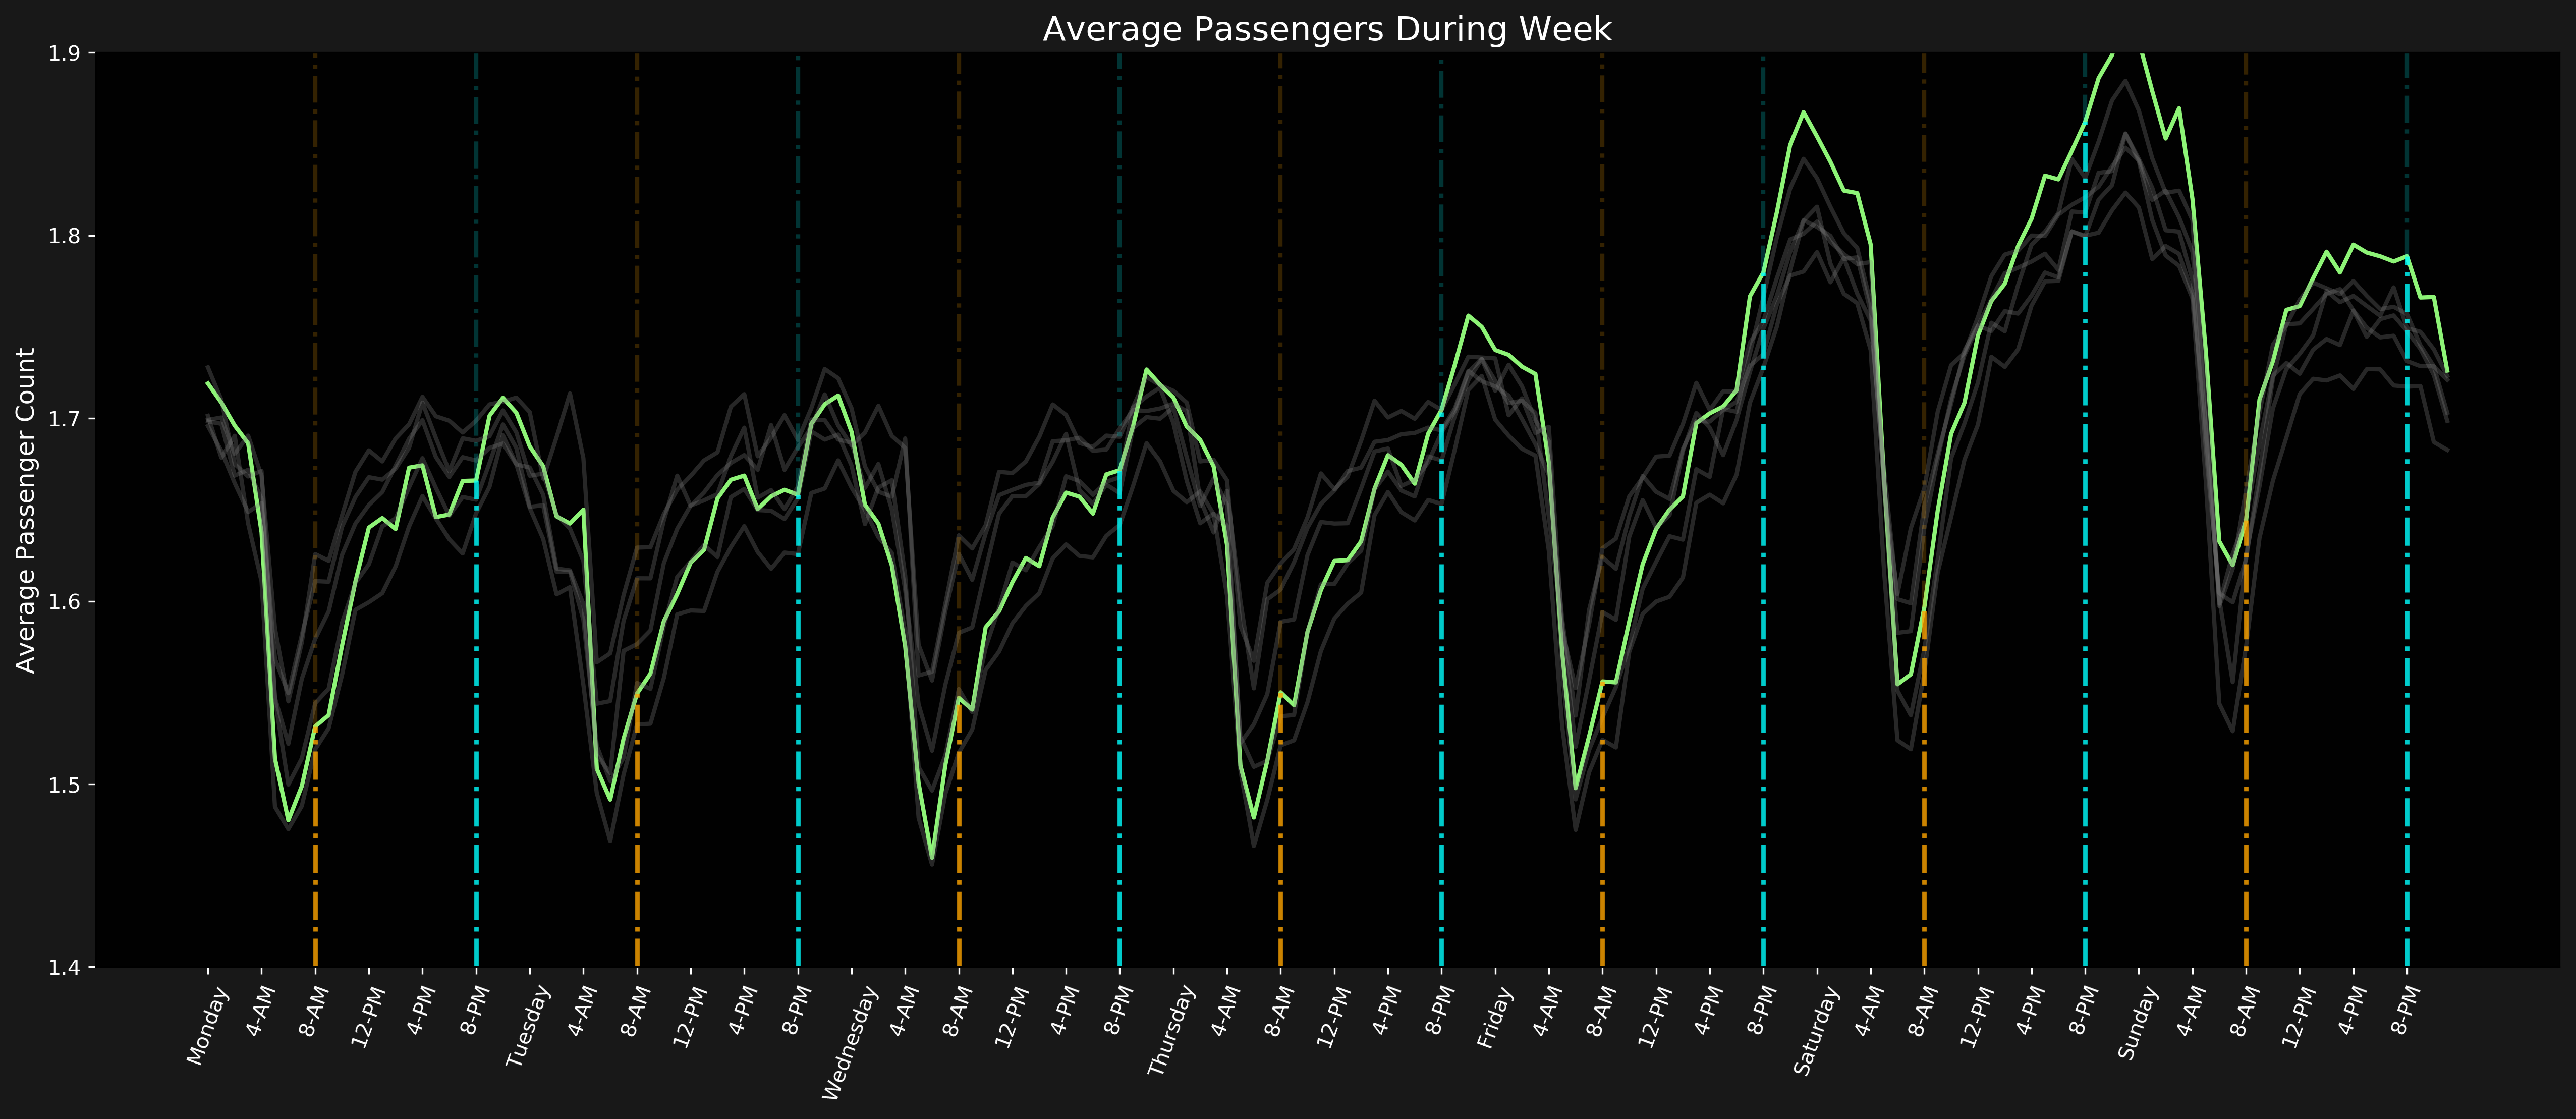

In [820]:
figures[2009]

# 3. Create Time Lapse Animation

- Install the anaconda version of ffmpeg in your environment. However, you may need to set the path to it afterward.
- Unfortunately, we cannot just reuse our previous function and will need to re-arrange things before creating the animation.

In [401]:
import matplotlib.pyplot as plt
plt.rcParams['animation.ffmpeg_path'] = '/Users/robertwoody/anaconda3/envs/pyviz-tutorial2/bin/ffmpeg'

In [834]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
with plt.rc_context({ 'xtick.color':'white', 'ytick.color':'white','axes.edgecolor':'white',\
                    'axes.spines.top':'False','axes.spines.left':'False','axes.spines.right':'False',\
                    'ytick.labelsize':'8'}):

    fig, ax = plt.subplots(figsize = (14,5.5))

#Create x ticks
x_labels = []  
ticks = [counter for counter,label in enumerate(labels) if counter%4==0]
ax.set_xticks(ticks)
fig.patch.set_facecolor('black')


for result in (list(result_dict.keys())):
    line_color="gray"
    temp_result = result_dict[result]
    ax.plot(temp_result['passenger_count'],linewidth=2,label=str(result),color=line_color,alpha=alpha)
#for readability, we create a separate list for the vertical lines, and keep track of the xvalue at which that
#vertical line should occur.
morning_lines =[]
morning_index = []
evening_lines = []
evening_index = []

# Create labels and inital time dividers
for counter,label in enumerate(labels):
    if counter %4 ==0:
        temp_label = label[1]
        if temp_label == "8-AM":

                #yline = target_result['passenger_count'][counter]
                #solid line
                morning_line, = ax.plot([counter,counter],[0,0],color='orange',linewidth = 1.5, linestyle = "-.")
                morning_lines.append([morning_line])
                #faded line
                morning_line, = ax.plot([counter,counter],[0,0],color='orange',alpha = .34,linewidth = 1.5, linestyle = "-.")
                morning_lines[-1].append(morning_line)
                
                morning_index.append(counter)
    
                
        if temp_label == "8-PM":
            #yline = target_result['passenger_count'][counter]
            #solid line
            evening_line, = ax.plot([counter,counter],[0,0],color='cyan',linewidth = 1.5,linestyle = "-.")
            evening_lines.append([evening_line])
            #faded line
            evening_line, = ax.plot([counter,counter],[0,0],color='cyan',alpha = .34,linewidth = 1.5, linestyle = "-.")
            evening_lines[-1].append(evening_line)
            
            evening_index.append(counter)
                
        if counter %24 ==0:
            temp_label = label[0]   
        x_labels.append(temp_label)

        

ax.set_xticklabels(x_labels,rotation = 70,size = 8)

ax.set_ylim(1.4,1.9)
ax.set_ylabel("Average Passenger Count", color = "white", size= 10)
ax.set_title("Average Passengers During Week", color = "white",size=12,fontweight="bold")

ax.patch.set_facecolor('black')



#8ef477
line, = ax.plot(result_dict[target_year]['passenger_count'],color = '#6dff6b',linewidth = 1.5)

#text = ax.text(20, 1.5, target_year, alpha = .7)


def animate(target_year):
    temp_data = result_dict[target_year]['passenger_count']
    line.set_ydata(list(temp_data))  # update the data
    
    for index,morning in zip(morning_index,morning_lines):
        morning[0].set_ydata([0,list(temp_data)[index]])
        morning[1].set_ydata([2,1.9-list(temp_data)[index]])
        
    for index,evening in zip(evening_index,evening_lines):
        evening[0].set_ydata([0,list(temp_data)[index]])
        evening[1].set_ydata([2,1.9-list(temp_data)[index]])


    return [line,]

def init():
    line.set_ydata([])
    
    return (line,)
#background = canvas.copy_from_bbox(fig.bbox))

ani = FuncAnimation(fig, animate, np.arange(2009, 2015), init_func=init, \
                              interval=1000, blit=True,repeat = False)

ani.save(filename = "average_passengers.mp4",savefig_kwargs={'facecolor':'black'})
video = HTML(ani.to_html5_video())
plt.close()
video
#fig.savefig('temp.png', facecolor=fig.get_facecolor(), edgecolor='none')


#ani.save(filename = "average_passengers.mp4",savefig_kwargs={'facecolor':'black'})
#savefig_kwargs={'facecolor':'black'}



### Whoah! Hold up.
What happened to the video? We lost the outside of it and the size is way off. Notice that the mp4
"average_passengers.mp4" saved to the local directory has the correct information. When we saved the video, we were able to specify savefig_kwargs={'facecolor':'black'}. Which allows the color of the figure patch to be changed in addition to the axis. Becasue this is not default behavior, when we convert the animation using the 
to_html5_video() method, the current state of the figure patch is not checked and updated. This gives us white areas around the axes, and white text, leading to "dissapearing" axes. However, we can get around this by embeding the mp4 as an html. While not as consice, we keep the black figure patch, and can go ahead and easily resize the video. This requires that we open the video, read it into memory, encode it in base64, and then reference it.

In [836]:
from IPython.display import HTML
import io
import base64
#<video width="80%" controls>
video = io.open('/Users/robertwoody/average_passengers.mp4', 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<div align="middle">
             <video alt="test" width="90%" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))


### And there we go! Our video with correct formating nicely embeded in the notebook.

# 4. Look at average price

In [823]:
figures_price = {}
for year in list(result_dict.keys()):
    figures_price[year] = average_size_year(result_dict,year,"fare_amount",[0,17],"Average Weekly Prices", "Average Price")
figures_price[2009]

## Create Time Lapse, change some formatting

In [877]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
with plt.rc_context({ 'xtick.color':'white', 'ytick.color':'white','axes.edgecolor':'white',\
                    'axes.spines.top':'False','axes.spines.left':'False','axes.spines.right':'False',\
                    'ytick.labelsize':'8'}):

    fig, ax = plt.subplots(figsize = (14,5.5))

#Create x ticks
x_labels = []  
ticks = [counter for counter,label in enumerate(labels) if counter%4==0]
ax.set_xticks(ticks)
fig.patch.set_facecolor('black')


for result in (list(result_dict.keys())):
    line_color="gray"
    temp_result = result_dict[result]
    ax.plot(temp_result['fare_amount'],linewidth=2,label=str(result),color=line_color,alpha=alpha)
#for readability, we create a separate list for the vertical lines, and keep track of the xvalue at which that
#vertical line should occur.
morning_lines =[]
morning_index = []
evening_lines = []
evening_index = []

# Create labels and inital time dividers
for counter,label in enumerate(labels):
    if counter %4 ==0:
        temp_label = label[1]
        if temp_label == "8-AM":

               
                #solid line
                morning_line, = ax.plot([counter,counter],[0,0],color='orange',linewidth = 1.5, linestyle = "-.")
                morning_lines.append([morning_line])
                #faded line
                morning_line, = ax.plot([counter,counter],[0,0],color='orange',alpha = .34,linewidth = 1.5, linestyle = "-.")
                morning_lines[-1].append(morning_line)
                
                morning_index.append(counter)
    
                
        if temp_label == "8-PM":
            #solid line
            evening_line, = ax.plot([counter,counter],[0,0],color='cyan',linewidth = 1.5,linestyle = "-.")
            evening_lines.append([evening_line])
            #faded line
            evening_line, = ax.plot([counter,counter],[0,0],color='cyan',alpha = .34,linewidth = 1.5, linestyle = "-.")
            evening_lines[-1].append(evening_line)
            
            evening_index.append(counter)
                
        if counter %24 ==0:
            temp_label = label[0]   
        x_labels.append(temp_label)

        

ax.set_xticklabels(x_labels,rotation = 70,size = 8)

ax.set_ylim(0,20)
ax.set_ylabel("Average Fare", color = "white", size= 10)
ax.set_title("Average Fare During Week", color = "white",size=12,fontweight="bold")

ax.patch.set_facecolor('black')

ax.plot(result_dict[2009]['fare_amount'],color = '#6dff6b',linewidth = 1.5)

#8ef477
line, = ax.plot(result_dict[target_year]['fare_amount'],color = 'salmon',linewidth = 1.5)

text = ax.text(79, 5, "2009", alpha = .7,color="white",size=14,fontdict={})


def animate(target_year):
    y2009 = result_dict[2009]['fare_amount']
    temp_data = result_dict[target_year]['fare_amount']
    line.set_ydata(list(temp_data))  # update the data
    
    for index,morning in zip(morning_index,morning_lines):
        morning[0].set_ydata([list(y2009)[index],list(temp_data)[index]])
        #morning[1].set_ydata([2,1.9-list(temp_data)[index]])
        
    for index,evening in zip(evening_index,evening_lines):
        evening[0].set_ydata([list(y2009)[index],list(temp_data)[index]])
        #evening[1].set_ydata([2,1.9-list(temp_data)[index]])
        
    text.set_text(str(target_year))


    return [line,]

def init():
    line.set_ydata([])
    
    return (line,)
#background = canvas.copy_from_bbox(fig.bbox))

ani = FuncAnimation(fig, animate, np.arange(2009, 2015), init_func=init, \
                              interval=1500, blit=True,repeat = False)

ani.save(filename = "average_fare.mp4",savefig_kwargs={'facecolor':'black'})
plt.close()


In [878]:
video = io.open('/Users/robertwoody/average_fare.mp4', 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<div align="middle">
             <video alt="test" width="90%" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))